In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr, ttest_ind, ttest_rel
import pandas as pd
import os


Index(['Region', 'DOF', 'Tau2', 'Tau2SE', 'I2', 'H2', 'Qdf', 'Q', 'Qp',
       'estimate', 'se', 'zval', 'pval', 'ci.lb', 'ci.ub'],
      dtype='object')
0.05 63 0.9
0.01 61 0.8714285714285714
0.005 60 0.8571428571428571
0.001 58 0.8285714285714286
Effect size: 0.4179229431770091 0.4213988773041959 0.0014524117129494 1.75941950774482
count    70.000000
mean      0.417923
std       0.421399
min       0.001452
25%       0.134890
50%       0.300000
75%       0.505346
max       1.759420
Name: estimate, dtype: float64


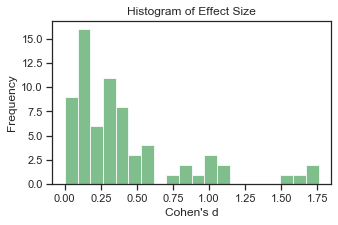

In [27]:
# load meta results and parameters preparation
meta_f = u'../meta/sum_asy_meta.csv'
meta_dat = pd.read_csv(meta_f)
print(meta_dat.columns)
csv_list =  meta_dat[u'Region']
pthr_list = [0.05, 0.01, 0.005, 0.001]
for pthr in pthr_list:
    print(pthr, np.sum(meta_dat[u'pval']<=pthr),\
    1.0*np.sum(meta_dat[u'pval']<=pthr)/meta_dat[u'pval'].count())
print('Effect size:', meta_dat[u'estimate'].abs().mean(), meta_dat[u'estimate'].abs().std(),\
        meta_dat[u'estimate'].abs().min(), meta_dat[u'estimate'].abs().max())

print(meta_dat[u'estimate'].abs().describe())
    
plt.figure(figsize=(5,3))
plt.hist(meta_dat[u'estimate'].abs(),facecolor='g', alpha=0.75, bins=20)
plt.xlabel('Cohen\'s d')
plt.ylabel('Frequency')
plt.title('Histogram of Effect Size')
plt.show()

meta_dat[u'estimate_abs'] = np.abs(meta_dat[u'estimate'])
#meta_dat_ordered = meta_dat.sort_values(u'estimate_abs',axis=0)
#csv_list_ordered =  meta_dat_ordered[u'Region']


In [28]:
# have an overview of data, i.e., to check whether there is any regional effect not showing any significant regions in any single dataset.
count_min_nonsig05 = 0
count_min_nonsig01 = 0
count_min_nonsig005 = 0
count_min_nonsig001 = 0

for i, csv_f in enumerate(csv_list): # for each regional effect
    meta_z = meta_dat[u'zval'][i]
    meta_p = meta_dat[u'pval'][i]
    csv_dat = pd.read_csv(os.path.join('../out',csv_f))
    if csv_dat[u'p'].min()>0.05:
        count_min_nonsig05+=1
    if csv_dat[u'p'].min()>0.01:
        count_min_nonsig01+=1
    if csv_dat[u'p'].min()>0.005:
        count_min_nonsig005+=1
    if csv_dat[u'p'].min()>0.001:
        count_min_nonsig001+=1
print(0.05, 0.01, 0.005, 0.001)
print(count_min_nonsig05, count_min_nonsig01, count_min_nonsig005,count_min_nonsig001)
print('if values above are all 0, this means that there is always a site successing finding sth. significant.')
print(csv_dat.columns)
# The results showed that there is always a significant result in a single dataset for one the 70 regional effets. 
# 0.05 was chosen for further analysis. 

0.05 0.01 0.005 0.001
0 0 0 0
if values above are all 0, this means that there is always a site successing finding sth. significant.
Index(['Dataset', 'N', 'Male', 'Female', 'Right', 'Left', 'AgeMin', 'AgeMax',
       'AgeMed', 'ICVMin', 'ICVMax', 'ICVMed', 'File', 'yi', 'vi', 'df', 't',
       'p', 'asy'],
      dtype='object')


In [29]:
# calculate reproducibility with different N
N_list = [15, 50, 100, 150, 200, 300, 400, 500]

# including both true positive and true negative
irr_mat_N = np.zeros((len(csv_list),len(N_list))) # intrinsic reproducibility, with min sample sizes
irr_mat_N2 = np.zeros((len(csv_list),len(N_list))) # intrinsic reproducibility, with sample ranges

metrics = ['Hemi']*2 + ['Thickness']*34 + ['Area']*34
pthr0 = 0.05
for i, csv_f in enumerate(csv_list):
    meta_z = meta_dat[u'zval'][i]
    meta_p = meta_dat[u'pval'][i]
    csv_dat = pd.read_csv(os.path.join('../out',csv_f))
    for j,N in enumerate(N_list):
        tmp = csv_dat[csv_dat[u'df']+1>=N] # for the main analysis, with min sample size
        if N < N_list[-1]:
            tmp2 = csv_dat[(csv_dat[u'df']+1>=N)&(csv_dat[u'df']+1<N_list[j+1])] # # for additioanl analysis, with sample size range
        else:
            tmp2 = csv_dat[csv_dat[u'df']+1>N]

        if meta_p <=pthr0:
            # significant & same direction
            num_sig = np.sum((tmp[u'p']<=pthr0)&((tmp[u't']*meta_z)>0))
            irr_mat_N[i,j] = num_sig*1.0/tmp[u'p'].count()
            
            num_sig = np.sum((tmp2[u'p']<=pthr0)&((tmp2[u't']*meta_z)>0))
            irr_mat_N2[i,j] = num_sig*1.0/tmp2[u'p'].count()
            
        else: # meta_p > pthr for ~false positive
            # significant & same direction
            num_nsig = np.sum(tmp[u'p']>pthr0)
            irr_mat_N[i,j] = num_nsig*1.0/tmp[u'p'].count()
            
            num_nsig = np.sum(tmp2[u'p']>pthr0)
            irr_mat_N2[i,j] = num_nsig*1.0/tmp2[u'p'].count()

# For each actual effect size, seperately.        
# including both true positive and true negative
d_list = [0, 0.2, 0.4, 0.6, 0.8]

irr_mat_N_e = np.zeros((len(d_list),len(N_list))) # intrinsic reproducibility
irr_mat_N2_e = np.zeros((len(d_list),len(N_list))) # intrinsic reproducibility

for i,d in enumerate(d_list): # for different effect ranges
    if d <0.8:
        csv_f_e_index = (np.abs(meta_dat[u'estimate'])>=d)&(np.abs(meta_dat[u'estimate'])<d_list[i+1])
    else:
        csv_f_e_index = np.abs(meta_dat[u'estimate'])>=d
    csv_f_e = csv_list[csv_f_e_index]
    csv_f_e_tmp = meta_dat[csv_f_e_index]
    
    for j,N in enumerate(N_list):
        sig_rates = []
        sig2_rates = []
        for tmp_i, csv_f in enumerate(csv_f_e):
            meta_z = csv_f_e_tmp[u'zval'][csv_f_e_tmp[u'Region']==csv_f].values
            meta_p = csv_f_e_tmp[u'pval'][csv_f_e_tmp[u'Region']==csv_f].values
            csv_dat = pd.read_csv(os.path.join('../out',csv_f))

            tmp = csv_dat[csv_dat[u'df']+1>=N]
            if N < N_list[-1]:
                tmp2 = csv_dat[(csv_dat[u'df']+1>=N)&(csv_dat[u'df']+1<N_list[j+1])]
            else:
                tmp2 = csv_dat[csv_dat[u'df']+1>N]
            #print meta_p
            if meta_p <=pthr0:
                # significant & same direction
                num_sig = np.sum((tmp[u'p']<=pthr0)&((tmp[u't']*meta_z)>0))
                num_all = tmp[u'p'].count()
            
                num_sig2 = np.sum((tmp2[u'p']<=pthr0)&((tmp2[u't']*meta_z)>0))
                num_all2 = tmp2[u'p'].count()

            else: # meta_p > pthr for ~false positive
                # significant & same direction
                num_sig = np.sum(tmp[u'p']>pthr0)
                num_all = tmp[u'p'].count()
            
                num_sig2 = np.sum(tmp2[u'p']>pthr0)
                num_all2 = tmp2[u'p'].count()
            
            sig_rates.append(num_sig*1.0/num_all)
            sig2_rates.append(num_sig2*1.0/num_all2)
            
        irr_mat_N_e[i,j] = np.mean(sig_rates)
        irr_mat_N2_e[i,j] = np.mean(sig2_rates)
print(irr_mat_N_e.shape)
print(irr_mat_N2_e.shape)


(5, 8)
(5, 8)


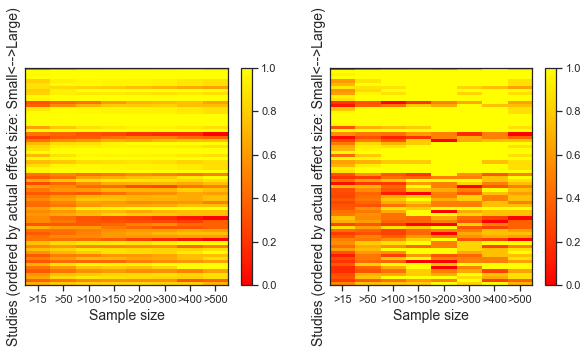

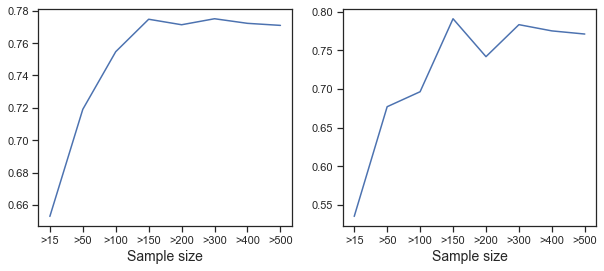

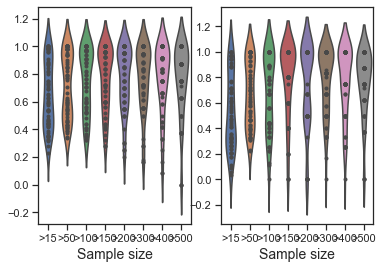

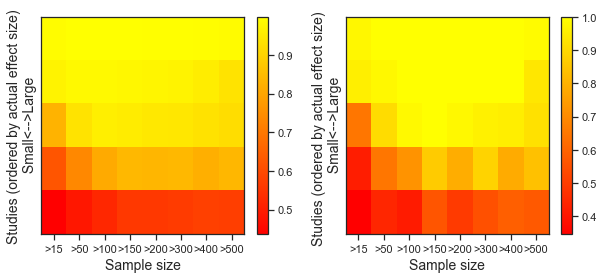

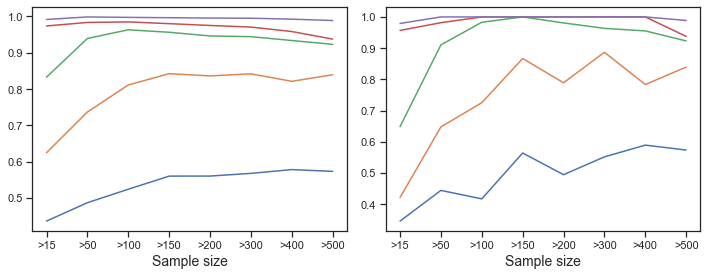

In [30]:
# for ploting
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(irr_mat_N, cmap='autumn',interpolation='none',aspect='auto',origin='lower')
plt.yticks([])
plt.ylabel("Studies (ordered by actual effect size: Small<-->Large)",fontsize=14)
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(irr_mat_N2, cmap='autumn',interpolation='none',aspect='auto',origin='lower')
plt.yticks([])
plt.ylabel("Studies (ordered by actual effect size: Small<-->Large)",fontsize=14)
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(len(N_list)),np.mean(irr_mat_N,axis=0))
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.subplot(1,2,2)
plt.plot(range(len(N_list)),np.mean(irr_mat_N2,axis=0))
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.show()

plt.subplot(1,2,1)
sns.violinplot(data=irr_mat_N, inner="points")
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.subplot(1,2,2)
sns.violinplot(data=irr_mat_N2, inner="points")
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.show()


# for ploting
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(irr_mat_N_e, cmap='autumn',interpolation='none',aspect='auto',origin='lower')
plt.yticks([])
plt.ylabel("Studies (ordered by actual effect size)\n Small<-->Large",fontsize=14)
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(irr_mat_N2_e, cmap='autumn',interpolation='none',aspect='auto',origin='lower')
plt.yticks([])
plt.ylabel("Studies (ordered by actual effect size) \n Small<-->Large",fontsize=14)
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
#plt.plot(range(len(N_list)),np.mean(irr_mat_N_e,axis=0))
for i in range(len(d_list)):
    plt.plot(range(len(N_list)),irr_mat_N_e[i,:])
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)

plt.subplot(1,2,2)
#plt.plot(range(len(N_list)),np.mean(irr_mat_N2_e,axis=0))
for i in range(len(d_list)):
    plt.plot(range(len(N_list)),irr_mat_N2_e[i,:])
plt.xticks(range(len(N_list)), ['>15','>50','>100','>150','>200','>300','>400','>500'])
plt.xlabel("Sample size", fontsize=14)
plt.tight_layout()
plt.show()


In [31]:
# calculate intrinsic reproducibility rate,IRR

# including both true positive and true negative
irr_mat = np.zeros((len(csv_list),len(pthr_list),len(pthr_list))) # intrinsic reproducibility

metrics = ['Hemi']*2 + ['Thickness']*34 + ['Area']*34
for i, csv_f in enumerate(csv_list):
    meta_z = meta_dat[u'zval'][i]
    meta_p = meta_dat[u'pval'][i]
    csv_dat = pd.read_csv(os.path.join('../out',csv_f))
    for j,pthr in enumerate(pthr_list):
        # for reproducibility rate with significant population-level 
        # asymmetry
        for k, pthr0 in enumerate(pthr_list):
            if meta_p <=pthr:
                # significant & same direction
                num_sig = np.sum((csv_dat[u'p']<=pthr0)&((csv_dat[u't']*meta_z)>0))
                irr_mat[i,j,k] = num_sig*1.0/csv_dat[u'p'].count()
            else: # meta_p > pthr for ~false positive
                # significant & same direction
                num_nsig = np.sum(csv_dat[u'p']>pthr0)
                irr_mat[i,j,k] = num_nsig*1.0/csv_dat[u'p'].count()

#np.savez_compressed('../meta/irr_nopublicationbias',csv_list, metrics,meta_dat[[u'estimate',u'zval']],pthr_list,irr_mat)

col_names = ['Region','Metric','estimate','Z']+['IRR_'+str(pthr) for pthr in pthr_list]

out_dat = np.concatenate((csv_list.values.reshape((len(csv_list),1)),
                          np.array(metrics).reshape((len(csv_list),1)),
                          meta_dat[u'estimate'].values.reshape((len(csv_list),1)),
                          meta_dat[u'zval'].values.reshape((len(csv_list),1)),
                          irr_mat[:,:,0]),axis=1)
out_dat = pd.DataFrame(data=out_dat, columns=col_names)
#print out_dat.columns
out_dat.to_csv(os.path.join('../meta','IRR_05.csv'))
#print np.mean(out_dat['IRR_0.05']), np.std(out_dat['IRR_0.05'])
#print out_dat[['IRR_'+str(pthr) for pthr in pthr_list]].describe()

out_dat = np.concatenate((csv_list.values.reshape((len(csv_list),1)),
                          np.array(metrics).reshape((len(csv_list),1)),
                          meta_dat[u'estimate'].values.reshape((len(csv_list),1)),
                          meta_dat[u'zval'].values.reshape((len(csv_list),1)),
                          irr_mat[:,:,1]),axis=1)
out_dat = pd.DataFrame(data=out_dat, columns=col_names)
#out_dat.to_csv(os.path.join('../meta','IRR_01.csv'))

out_dat = np.concatenate((csv_list.values.reshape((len(csv_list),1)),
                          np.array(metrics).reshape((len(csv_list),1)),
                          meta_dat[u'estimate'].values.reshape((len(csv_list),1)),
                          meta_dat[u'zval'].values.reshape((len(csv_list),1)),
                          irr_mat[:,:,2]),axis=1)
out_dat = pd.DataFrame(data=out_dat, columns=col_names)
#out_dat.to_csv(os.path.join('../meta','IRR_005.csv'))

out_dat = np.concatenate((csv_list.values.reshape((len(csv_list),1)),
                          np.array(metrics).reshape((len(csv_list),1)),
                          meta_dat[u'estimate'].values.reshape((len(csv_list),1)),
                          meta_dat[u'zval'].values.reshape((len(csv_list),1)),
                          irr_mat[:,:,3]),axis=1)
out_dat = pd.DataFrame(data=out_dat, columns=col_names)
#out_dat.to_csv(os.path.join('../meta','IRR_001.csv'))


col_names = ['Region','Metric','estimate','Z', 'pval']+\
            ['IRR_05_'+str(pthr) for pthr in pthr_list] +\
            ['IRR_01_'+str(pthr) for pthr in pthr_list] +\
            ['IRR_005_'+str(pthr) for pthr in pthr_list] +\
            ['IRR_001_'+str(pthr) for pthr in pthr_list]
out_dat = np.concatenate((csv_list.values.reshape((len(csv_list),1)),
                          np.array(metrics).reshape((len(csv_list),1)),
                          meta_dat[u'estimate'].values.reshape((len(csv_list),1)),
                          meta_dat[u'zval'].values.reshape((len(csv_list),1)),
                          meta_dat[u'pval'].values.reshape((len(csv_list),1)),
                          irr_mat[:,:,0],
                          irr_mat[:,:,1],
                          irr_mat[:,:,2],
                          irr_mat[:,:,3],),axis=1)
irr_out_dat = pd.DataFrame(data=out_dat, columns=col_names)
#irr_out_dat.to_csv(os.path.join('../meta','IRR_001.csv'))


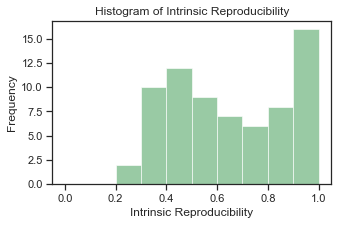

In [32]:
# 0.05 0.05 threshold results
plt.figure(figsize=(5,3))
plt.hist(irr_mat[:,0,0],facecolor='g', alpha=0.6, range=(0,1))
plt.xlabel('Intrinsic Reproducibility')
plt.ylabel('Frequency')
plt.title('Histogram of Intrinsic Reproducibility')
plt.show()


(29, 8)
(15, 8)
(13, 8)
(2, 8)
(11, 8)


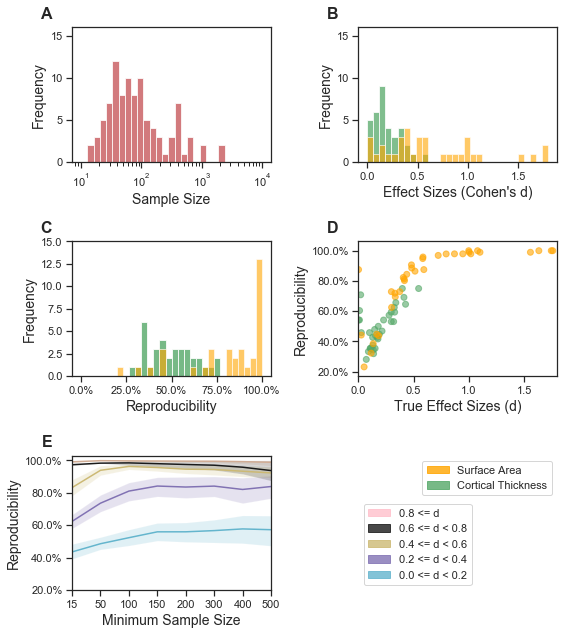

In [53]:
sns.set(style="ticks")

# plot histgram of sample sizes
fig = plt.figure(figsize=(8,9))

ax = fig.add_subplot(3,2,1)
ax.text(-0.1, 1.15, 'A', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
plt.hist(csv_dat[u'df'].dropna(how='any'), alpha=0.75, bins=np.logspace(1, 4, 30), facecolor='r')
plt.gca().set_xscale("log")
plt.xlabel('Sample Size', fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.ylim((0,16))
#plt.title('Histogram of Sample Sizes')

# plot histgram of effect sizes
ax = fig.add_subplot(3,2,2)
ax.text(-0.1, 1.15, 'B', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
#plt.hist(meta_dat[u'estimate'].abs(), alpha=0.75, bins=30, facecolor='orange')
thick_index = [False,True]+[True]*34+[False]*34
area_index = [True,False]+[False]*34+[True]*34
plt.hist(meta_dat[u'estimate_abs'][thick_index], facecolor='g', alpha=0.75, range=(0,1.8), bins=30)
plt.hist(meta_dat[u'estimate_abs'][area_index], facecolor='orange', alpha=0.6, range=(0,1.8), bins=30)

plt.xlabel('Effect Sizes (Cohen\'s d)',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.ylim((0,16))
#plt.title('Histogram of Effect Size')


from matplotlib.ticker import FuncFormatter
import matplotlib
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

# plot histgram of reprudicibility 
ax = fig.add_subplot(3,2,3)
ax.text(-0.1, 1.15, 'C', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
thick_index = [False,True]+[True]*34+[False]*34
area_index = [True,False]+[False]*34+[True]*34

#plt.hist(irr_out_dat['IRR_05_0.05'], alpha=0.8, range=(0,1), bins=30)
plt.hist(irr_out_dat['IRR_05_0.05'][thick_index].astype(float), facecolor='g', alpha=0.8, range=(0,1), bins=30)
plt.hist(irr_out_dat['IRR_05_0.05'][area_index].astype(float), facecolor='orange', alpha=0.6, range=(0,1), bins=30)
plt.xlabel('Reproducibility', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim((0,15))
plt.xticks(np.arange(0, 1.01, step=0.25)) ###
#plt.title('Histogram of Reproducibility Rate')
formatter = FuncFormatter(to_percent)
plt.gca().xaxis.set_major_formatter(formatter)

# plot scatter plot of effect sizes (abs.) and reproducibility 
ax = fig.add_subplot(3,2,4)
ax.text(-0.1, 1.15, 'D', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
colors = ['orange','g']+['g']*34+['orange']*34
plt.scatter(meta_dat[u'estimate'].abs(), irr_out_dat['IRR_05_0.05'], color=colors, alpha=0.6)
plt.xlabel('True Effect Sizes (d)', fontsize=14)
plt.xlim((0, 1.8))
plt.ylabel('Reproducibility',fontsize=14)
plt.yticks((0.2, 0.4, 0.6, 0.8, 1.0))
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

# color block for group of each sample size level and effect size level 
#plt.subplot(3,2,5)


# time series plot for reproducibility for each sample size and effect size level
ax = fig.add_subplot(3,2,5)
ax.text(-0.1, 1.15, 'E', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
color_list = ['c', 'm', 'y', 'k', 'pink']
for i,d in enumerate(d_list):
    if d <d_list[-1]:
        csv_f_e_index = (np.abs(meta_dat[u'estimate'])>=d)&(np.abs(meta_dat[u'estimate'])<d_list[i+1])
    else:
        csv_f_e_index = np.abs(meta_dat[u'estimate'])>=d
    print(irr_mat_N[csv_f_e_index.values,:].shape)
    sns.tsplot(data=irr_mat_N[csv_f_e_index.values,:], ci=[95], color=color_list[i])
    
plt.xticks(range(len(N_list)), ['15','50','100','150','200','300','400','500','1000'])
plt.xlabel("Minimum Sample Size", fontsize=14)
plt.ylabel("Reproducibility", fontsize=14)
plt.yticks((0.2, 0.4, 0.6, 0.8, 1.0))
#plt.title("Reproducibility Changes with \n Sample Size and Actual Effect Size", fontsize=14)

formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

# color legends
plt.subplot(3,2,6)
import matplotlib.patches as mpatches
plt.axis('off')
#all_patch = mpatches.Patch(label='All', alpha=0.80)
red_patch = mpatches.Patch(color='orange', label='Surface Area', alpha=0.80)
green_patch = mpatches.Patch(color='g', label='Cortical Thickness', alpha=0.80)
first_legend = plt.legend(handles=[red_patch, green_patch], loc='upper right')
ax = plt.gca().add_artist(first_legend)

c_patch = mpatches.Patch(color='c', label='0.0 <= d < 0.2', alpha=0.80)
m_patch = mpatches.Patch(color='m', label='0.2 <= d < 0.4', alpha=0.80)
y_patch = mpatches.Patch(color='y', label='0.4 <= d < 0.6', alpha=0.80)
k_patch = mpatches.Patch(color='k', label='0.6 <= d < 0.8', alpha=0.80)
w_patch = mpatches.Patch(color='pink', label='0.8 <= d', alpha=0.80)
plt.legend(handles=[c_patch, m_patch, y_patch, k_patch, w_patch][::-1], loc='lower left')


plt.tight_layout()
plt.show()
#plt.savefig('Fig0_py3.tif',dpi=600,bbox_inches='tight')


In [23]:
# description outputs
print(meta_dat['estimate_abs'][2:36].mean(), meta_dat['estimate_abs'][2:36].std())
print(meta_dat['estimate_abs'][36:].mean(), meta_dat['estimate_abs'][36:].std())
print(ttest_rel(meta_dat['estimate_abs'][2:36], meta_dat['estimate_abs'][36:]))

print(irr_out_dat['IRR_05_0.05'].mean(), irr_out_dat['IRR_05_0.05'].std())
print(irr_out_dat['IRR_05_0.05'].max(), irr_out_dat['IRR_05_0.05'].min())

print('thickness')
print(irr_out_dat['IRR_05_0.05'][2:36].max(), irr_out_dat['IRR_05_0.05'][2:36].min())
print(irr_out_dat['IRR_05_0.05'][2:36].mean(), irr_out_dat['IRR_05_0.05'][2:36].std())

print('area')
print(irr_out_dat['IRR_05_0.05'][36:].max(), irr_out_dat['IRR_05_0.05'][36:].min())
print(irr_out_dat['IRR_05_0.05'][36:].mean(), irr_out_dat['IRR_05_0.05'][36:].std())

print(ttest_rel(irr_out_dat['IRR_05_0.05'][2:36], irr_out_dat['IRR_05_0.05'][36:]))

print('correlations')
print(spearmanr(irr_out_dat['IRR_05_0.05'], np.abs(irr_out_dat['estimate'])))
print(spearmanr(irr_out_dat['IRR_05_0.05'][2:36], np.abs(irr_out_dat['estimate'][2:36])))
print(spearmanr(irr_out_dat['IRR_05_0.05'][36:], np.abs(irr_out_dat['estimate'][36:])))


0.1959632163194634 0.13520121243289446
0.6507718704577777 0.4936566439116254
Ttest_relResult(statistic=-4.849070786987431, pvalue=2.8758528843698147e-05)
0.652578152011807 0.23864080557900608
1.0 0.23157894736842105
thickness
0.75 0.28125
0.5027638715060492 0.12955922773322345
area
1.0 0.23157894736842105
0.8093165343386931 0.22686114098379603
Ttest_relResult(statistic=-6.332900884687541, pvalue=3.6337724921998154e-07)
correlations
SpearmanrResult(correlation=0.8419542610822472, pvalue=6.82941268695345e-20)
SpearmanrResult(correlation=0.5171759729009343, pvalue=0.0017359267993163421)
SpearmanrResult(correlation=0.9372153363757432, pvalue=3.411022924220337e-16)
